# Run the Keller-Segel program from Jupyter (Python)

Este cuaderno Jupyter se utiliza para ejecutar un programa (un *script*) en lenguaje [FreeFem++](www.freefem.org), con el fin de resolver numéricamente las ecuaciones de Keller-Segel:
$$
\begin{align}
u_t &= \Delta u - \nabla\cdot(u \nabla v),\\
v_t &= \Delta v - v + u,\\
\end{align}
$$
con condiciones de contorno
$$
\nabla u \cdot n = \nabla v \cdot n = 0 
$$
y post-procesar la salida, generando gráficas etc.

## 1. Crea un oggetto (che chiamiamo "freefem") per eseguire lo script

Prima, definiamo i parametri che lo script utilizzerà

In [14]:
# Load module to run programs
import pyrunner as pr

# Ruta a la carpeta donde está el script en lenguaje FreeFem++ (.edp)
keller_segel_path = "~/inves/keller-segel/keseites"
# Nombre del script
edp_file = "keller-segel.edp"
# Args passed to script
dt, nt = 1e-4, 200 # Time step and number of steps
edp_args = { "-dt": dt, "-nt": nt }
# Object specialized in running FreeFem++ scripts
freefem = pr.FreeFemRunner(
        edp_file, 
        path = keller_segel_path,
        args = edp_args
    )

## 2.- Esegui lo script e filtra l'output per ottenere i dati che ci interessano

L'esecuzione del programma tramite il modulo *pyrunner* ci consente di accedere a ciascuna riga dell'output della tua console. Attraverso di esso, accediamo ai dati prodotti dal programma. Questi dati vengono utilizzati per generare (in tempo reale) una tabella di risultati, attraverso il modulo *panda* e un grafico finale. Inoltre, l'evoluzione nel tempo viene indicata mediante una barra di avanzamento (utilizzando il modulo *ipywidgets*).

La ejecución del programa mediante el módulo *pyrunner* nos permite acceder a cada línea de su salida en consola. A través de ella, accedemos a los datos que produce el programa. Estos datos se utilizan para generar (en tiempo real) una tabla de resultados, mediante el módulo *pandas* y una gráfica final. Además, se muestra la evolución en tiempo mediante una barra de progreso (utilizando el módulo *ipywidgets*).

IntProgress(value=0, description='Time:', max=200)

,time,max(u),max(v)
1,0.0001,299.282,140.743
50,0.0050,635.782,138.738
100,0.0100,1252.930,138.785
150,0.0150,2437.100,141.699
200,0.0200,5452.210,148.995


Running command:
FreeFem++ -nw  -cd  -ne  ~/inves/keller-segel/keseites/keller-segel.edp -nt 200 -dt 0.0001


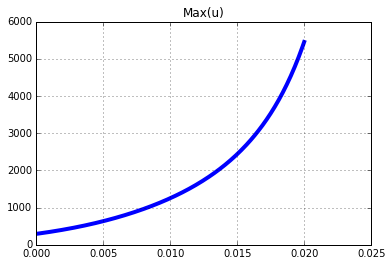

Raw data: max(u) = [299.282, 304.233, 309.253, 314.342, 319.502, 324.732, 330.034, 335.409, 340.856, 346.377, 351.973, 357.643, 363.389, 369.212, 375.111, 381.088, 387.144, 393.279, 399.493, 405.789, 412.165, 418.623, 425.164, 431.789, 438.497, 445.291, 452.169, 459.134, 466.186, 473.326, 480.555, 487.872, 495.28, 502.779, 510.369, 518.051, 525.827, 533.697, 541.662, 549.722, 557.879, 566.133, 574.486, 582.938, 591.489, 600.142, 608.897, 617.755, 626.716, 635.782, 644.955, 654.234, 663.62, 673.116, 682.722, 692.439, 702.269, 712.212, 722.269, 732.443, 742.734, 753.143, 763.671, 774.321, 785.093, 795.989, 807.01, 818.158, 829.434, 840.84, 852.377, 864.047, 875.852, 887.793, 899.872, 912.091, 924.451, 936.955, 949.605, 962.402, 975.349, 988.448, 1001.7, 1015.11, 1028.68, 1042.4, 1056.29, 1070.35, 1084.57, 1098.97, 1113.54, 1128.28, 1143.2, 1158.31, 1173.6, 1189.08, 1204.75, 1220.61, 1236.67, 1252.93, 1269.4, 1286.07, 1302.96, 1320.06, 1337.38, 1354.93, 1372.7, 1390.71, 1408.95, 1427.43, 

In [15]:
%%timeit -n 1 -r 1 # Ejecutar esta celda una sola vez vez y medir el tiempo

# For graphics
import numpy as np
import matplotlib.pyplot as plt

# For tables
from pandas import DataFrame
from IPython.display import DisplayHandle

# For progress bar
import ipywidgets as widgets

# Show time in a progress bar widget
progress_bar = widgets.IntProgress(
    min=0,
    max=nt,
    description='Time:' )
display(progress_bar)

# Display data in a table
df = DataFrame(columns=["time", "max(u)","max(v)"])
handle = DisplayHandle()
handle.display(df)

# Run program and capture output (real time!)
output_lines = []
print_output = False
t=[]; u=[]; v=[]
i = 0
print("Running command:\n" + fr.get_command())
for line in freefem.run():
    output_lines.append(line.data())
    if print_output: print(line)
    
    # Does this line contains time?
    time_found = line.find_float("t={}")
    if time_found:
        time = float(time_found)
        t.append(time)
        i = i+1
        progress_bar.value = i
        progress_bar.description = "{}/{} iter".format(i, nt)
        
    # Does this line contains max(u)?
    max_u_found = line.find_float("max\(u\): {}") 
    if max_u_found:
        max_u = float(max_u_found)
        u.append(max_u)
        
   # Does this line contains max(v)?
    max_v_found = line.find_float("max\(v\): {}")       
    if max_v_found:
        max_v = float(max_v_found)
        v.append(max_v)

        if i== 1 or i % 50 == 0: # Show some lines in a table
            df.loc[i] = [time, max_u, max_v] 
            handle.update(df)

# Finished, plot result
plt.grid()
plt.plot(t, u, lw=4)    
plt.title("Max(u)")
plt.show()

# And also dump the data obtained
print("Raw data: max(u) =", u, "\n")
print("Raw data: max(v) =", v, "\n")
print("Computing time:")